In [ ]:
from derive_conceptualspace.evaluate.shallow_trees import classify_shallowtree
from derive_conceptualspace.pipeline import SnakeContext, load_envfiles
from derive_conceptualspace.util.result_analysis_tools import get_best_conf, highlight_nonzero_max, highlight_max
from derive_conceptualspace.cli.args_from_filename import get_filename, print_envvars
from misc_util.logutils import setup_logging

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Let's first create a quick table of the best configs

In [ ]:
import pandas as pd
import numpy as np
import pyperclip
from derive_conceptualspace.util.result_analysis_tools import df_to_latex, shorten_met
from derive_conceptualspace.util.desc_object import DescriptionList
from derive_conceptualspace.pipeline import cluster_loader
from joblib import parallel_backend
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import Markdown
flatten = lambda l: [item for sublist in l for item in sublist] 

In [ ]:
setup_logging()
load_envfiles("siddata")

In [ ]:
conf_results = get_best_conf("fachbereich", verbose=False, balance_classes=True, 
                             one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.3, return_all=True, nprocs=5)

In [ ]:
styles = [{'selector': 'th', 'props': [('vertical-align','top'),('text-align','left')]}]  #('border-style', 'solid')
styler = lambda df: df.style.format('{:.2%}'.format, na_rep="-").format_index(precision=1,axis=1).set_table_styles(styles) #{"amax": '{:.0%}'.format, "mean": '{:.2%}'.format}
pd.set_option("display.precision", 4)

df = conf_results.T.unstack(level=["classifier_succmetric", "embed_dimensions", "sec_lambda"])
df.index = pd.MultiIndex.from_arrays(list(zip(*[[shorten_met(j) for j in i] for i in df.index])), names=df.index.names)
df.columns = pd.MultiIndex.from_arrays(list(zip(*[[shorten_met(j) for j in i] for i in df.columns])), names=df.columns.names)

display(styler(df).apply(highlight_max, axis=None))

pyperclip.copy(df_to_latex(df, styler, rotate=False, caption="Decision-Tree-Accuracies for different Parameter-Combinations"))

In [ ]:
print(df_to_latex(df, styler, rotate=False, caption="Decision-Tree-Accuracies for different Parameter-Combinations"))

## Next: Robust accuracies for different depths

In [ ]:
# best_conf = {k: str(v) for k, v in dict(zip(conf_results.columns.names, conf_results.T.idxmax()[0])).items()}
best_conf = {'pp_components': 'mfauhcsd2', 'quantification_measure': 'tfidf', 'embed_dimensions': '200', 'dcm_quant_measure': 'count', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'sec_lambda': '0.2'}
print("Best conf:", best_conf)

ctx = SnakeContext.loader_context(config={**best_conf, "debug": False}, silent=True)
ctx.print_important_settings()
descriptions, clusters, embedding = ctx.load("pp_descriptions", "clusters", "embedding", 
                  loaders=dict(pp_descriptions=DescriptionList.from_json, clusters=cluster_loader, embedding=lambda **args: args["embedding"].embedding_))

In [ ]:
metrics = ["accuracy", "f1"]
all_scores = {}
for depth in [1, 2, 3, None]:
    with parallel_backend('threading', n_jobs=7):
        scores, clsizes = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True,
                                               classes="fachbereich", dt_depth=depth, test_percentage_crossval=5, metric=metrics, repeat=10, pgbar=True)
        scores = dict(sorted(scores.items(), key=lambda x: list(ctx.obj["dataset_class"].FB_MAPPER.values()).index(x[0])))
    for m in metrics:
        all_scores.setdefault(depth, {})[m] = {k: np.array(flatten([i[f"test_{m}"] for i in v])) for k, v in scores.items()}

In [ ]:
res = pd.DataFrame(all_scores[1]["accuracy"])
fig, ax = plt.subplots(figsize = [8, 5])
res.boxplot(ax=ax, vert=False, fontsize=14, patch_artist=True, medianprops=dict(color="red", linewidth=1.5), whiskerprops = dict(linestyle='-',linewidth=2.0), capprops=dict(linewidth=2.0));

with PdfPages("/home/chris/Documents/UNI_neu/Masterarbeit/MastersThesisText/graphics/dataset_new/accuracy_boxplots.pdf") as pdf:
    plt.show()
    pdf.savefig(fig, bbox_inches='tight')

In [ ]:
res = pd.concat([pd.DataFrame(pd.DataFrame(all_scores[depth][metric]).unstack(), columns=pd.MultiIndex.from_product([[depth], [metric]], names=["depth","metric"])).T for depth, v in all_scores.items() for metric, v2 in v.items()])
res

In [ ]:
import seaborn as sns
# r2 = res.stack(level=0).reset_index().rename(columns={"level_2": "faculty"})
r2 = res.unstack(level=[0,1]).reset_index(level=1, drop=True).reset_index(name='data').rename(columns={"level_0": "faculty"})
r2["depth"] = r2["depth"].fillna("any")

for metric in r2["metric"].unique():
    fig, ax = plt.subplots(figsize = [16, 10])
    display(Markdown(f"### {metric}"))
    ax = sns.boxplot(x='depth', y='data', hue="faculty", data=r2[r2["metric"] == metric], palette="Set3", ax=ax)
    plt.show()

In [ ]:
styles = [{'selector': 'th', 'props': [('vertical-align','top'),('text-align','left')]}] #('border-style', 'solid')  #see https://stackoverflow.com/a/55904239/5122790
styler = lambda df: df.style.format('{:.3f}'.format, na_rep="-").set_table_styles(styles)

summarized = {}
for depth, v in all_scores.items():
    for metric, scores in v.items():
        scores_df = pd.concat([pd.DataFrame(scores).agg((min, np.mean, max, np.std), axis="rows"), pd.DataFrame(clsizes, index=["samples"])])
        scores_df["unweighted_mean"] = scores_df.loc[["min", "mean", "max", "std"]].mean(axis=1)
        scores_df["weighted_mean"] = (scores_df.loc[["min", "mean", "max", "std"]] * scores_df.loc["samples"] / scores_df.loc["samples"].sum()).sum(axis=1)
        scores_df.loc["samples", ["unweighted_mean", "weighted_mean"]] = scores_df.loc["samples"].sum()
#         display(Markdown(f"### depth {depth}, metric {metric}"))
#         display(styler(scores_df.T))
        summarized[(depth, metric)] = scores_df.loc[["mean", "std"], :]

In [ ]:
summarized_all = pd.DataFrame({smkey: {i[0]: f"{i[1]['mean']:.3f} ± {i[1]['std']:.3f}" for i in sm.T.iterrows()} for smkey, sm in summarized.items()})
# display(summarized_all)
style = [{'selector': 'th', 'props': [('text-align','center')]}]

for metric in ["accuracy", "f1"]:
    display(Markdown(f"## {metric}"))
    df = summarized_all.T.xs(metric, level=1).T
    df.columns = [int(i) if isinstance(i,float) else i for i in df.columns.fillna("any")]
    pyperclip.copy(df.style.set_table_styles(style).to_latex(convert_css=True, clines="skip-last;index", multirow_align="t", hrules=True, siunitx=False))
    display(df)

## What about not 1-vs-rest?

In [ ]:
metrics = ["accuracy", "f1_macro"]
new_scores = {}
for depth in [1, 2, 3, None]:
    with parallel_backend('threading', n_jobs=7):
        scores, clsizes = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=False,
                                               classes="fachbereich", dt_depth=depth, test_percentage_crossval=5, metric=metrics, repeat=10, pgbar=True)
    for m in metrics:
        new_scores.setdefault(depth, {})[m] = np.array(flatten([i[f"test_{m}"] for i in scores]))

In [ ]:
df = pd.concat([pd.DataFrame(pd.DataFrame(new_scores[depth][metric]).unstack(), columns=pd.MultiIndex.from_product([[depth], [metric]], names=["depth","metric"])).T for depth, v in new_scores.items() for metric, v2 in v.items()])
df.index = pd.MultiIndex.from_tuples([(1, 'Accuracy'), (1, 'F1'), (2, 'Accuracy'), (2, 'F1'), (3, 'Accuracy'), (3, 'F1'), ("any", 'Accuracy'), ("any", 'F1')], names=['depth', 'metric'])
df = pd.DataFrame({i[0] if not pd.isna(i[0]) else "any": f"{i[1].mean():.3f} ± {i[1].std():.3f}" for i in df.iterrows()}, index=[""]).stack()
pyperclip.copy(df.style.to_latex(convert_css=True, multirow_align="t", hrules=True, siunitx=False))
df

## Ok, now, Decision-Tree for best config

In [ ]:
conf, perf = get_best_conf("fachbereich", verbose=True, balance_classes=True, one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33)

In [ ]:
print_envvars(get_filename(conf, get_dependencies=False, doprint=False))

In [ ]:
ctx = SnakeContext.loader_context(config=conf, silent=True, warn_filters=["DifferentFileWarning"])
ctx.print_important_settings()
cluster_reprs, clusters, embedding, descriptions = ctx.load("cluster_reprs", "clusters", "embedding", "pp_descriptions")

# Classifying Fachbereich

### Sample one (best 05.03.2022)

In [ ]:
from derive_conceptualspace.util.result_analysis_tools import getfiles_allconfigs
confs, print_conf = getfiles_allconfigs("clusters", dataset="siddata2022", verbose=False)

# best_conf = {'pp_components': 'mfauhcsd2', 'quantification_measure': 'tfidf', 'embed_dimensions': '200', 'dcm_quant_measure': 'count', 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'sec_lambda': '0.2'}
best_conf = {**confs[0], **best_conf, "debug": False}
print(best_conf)
print()
print_envvars(get_filename({**best_conf, "debug": False}, get_dependencies=False, doprint=False))

In [ ]:
ctx = SnakeContext.loader_context(config=best_conf, silent=True)
ctx.print_important_settings()
descriptions, clusters, embedding, cluster_reprs = ctx.load("pp_descriptions", "clusters", "embedding", "cluster_reprs",
                  loaders=dict(pp_descriptions=DescriptionList.from_json, clusters=cluster_loader, embedding=lambda **args: args["embedding"].embedding_))

In [ ]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33,
                       classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=True)[0]

### Sample two (best before 05.03.2022, keep me!)

<span style="font-size:11pt">Using classes from fachbereich - 7319/11942 entities have a class</span>

<span style="font-size:11pt">Labels (10 classes): <span style="color: #0000ff">Sprach-/Literaturwissenschaften</span>: 1723, <span style="color: #0000ff">Erziehungs-/Kulturwissenschaften</span>: 2090, <span style="color: #0000ff">Kultur-/Geowissenschaften</span>: 1457, <span style="color: #0000ff">Sozialwissenschaften</span>: 707, <span style="color: #0000ff">Rechtswissenschaften</span>: 350, <span style="color: #0000ff">Humanwissenschaften</span>: 376, <span style="color: #0000ff">Biologie/Chemie</span>: 167, <span style="color: #0000ff">Mathematik/Informatik</span>: 197, <span style="color: #0000ff">Physik</span>: 147, <span style="color: #0000ff">Wirtschaftswissenschaften</span>: 105</span>

<span style="font-size:11pt">Eval-Settings: type: <span style="color: #0000ff">one-vs-rest</span>, DT-Depth: <span style="color: #0000ff">1</span>, train-test-split:<span style="color: #0000ff"> 33.0% in test-set </span></span>

Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.
Some nodes will be renamed.


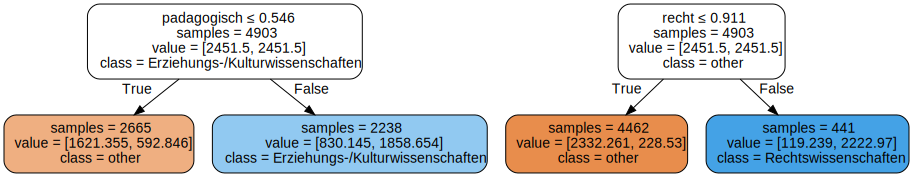

<span style="font-size:11pt"><br><br></span>

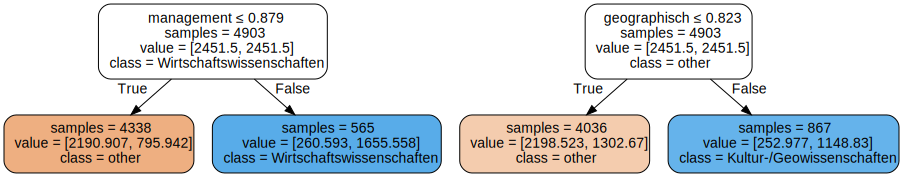

<span style="font-size:11pt"><br><br></span>

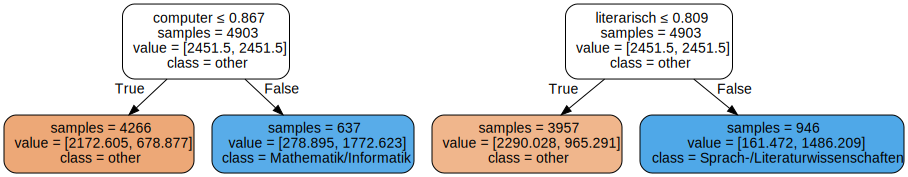

<span style="font-size:11pt"><br><br></span>

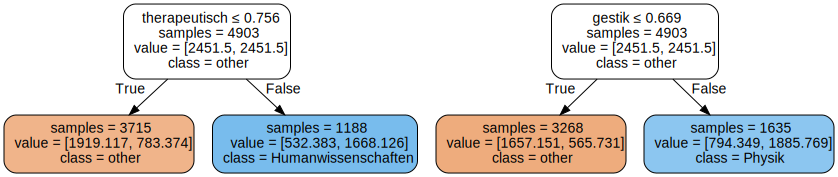

<span style="font-size:11pt"><br><br></span>

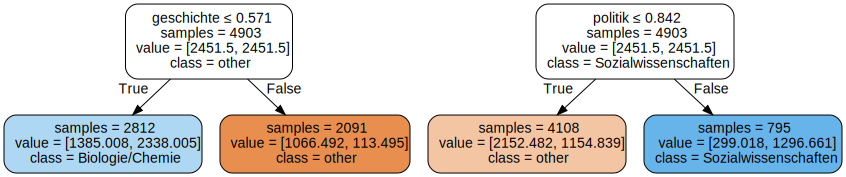

<span style="font-size:11pt"><br><br></span>

<span style="font-size:11pt">Per-Class-Scores: Erziehungs-/Kulturwissenschaften: 0.68, Rechtswissenschaften: 0.95, Wirtschaftswissenschaften: 0.88, Kultur-/Geowissenschaften: 0.81, Mathematik/Informatik: 0.87, Sprach-/Literaturwissenschaften: 0.86, Humanwissenschaften: 0.77, Physik: 0.68, Biologie/Chemie: 0.46, Sozialwissenschaften: 0.86</span>

<span style="font-size:11pt">Unweighted Mean Accuracy: 78.17%</span>

<span style="font-size:11pt">Weighted Mean Accuracy: 78.50%</span>

In [ ]:
# res = classify_shallowtree_multi(clusters, embedding, descriptions, ctx.obj["dataset_class"], verbose=True)
res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33, 
                           classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=False, balance_classes=True, do_plot=True)

<br><br><br><br><br><br><br><br>

# Classifying DDC

In [ ]:
res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33, 
                           classes="ddc_l1", cluster_reprs=cluster_reprs, verbose=False, return_features=False, balance_classes=True, do_plot=True)

## Another one, cause the other also looked good

In [ ]:
conf = {'dataset': 'siddata2022', 'debug': False, 'kappa_weights': 'quadratic', 'embed_dimensions': 200, 'embed_algo': 'mds', 'quantification_measure': 'tfidf', 'dcm_quant_measure': 'count', 'extraction_method': 'tfidf', 'translate_policy': 'onlyorig', 'pp_components': 'mfauhtcsldp', 'language': 'de', 'min_words_per_desc': 80, 'prim_lambda': 0.5, 'sec_lambda': 0.2, 'classifier_succmetric': 'kappa_digitized_onlypos_2', 'cluster_direction_algo': 'reclassify'}
ctx = SnakeContext.loader_context(config=conf, silent=True)
ctx.print_important_settings()
clusters, embedding, descriptions = ctx.load("clusters", "embedding", "pp_descriptions")

res = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=1, test_percentage_crossval=0.33,
                           classes="ddc_l1", verbose=False, return_features=False, balance_classes=True, do_plot=True)

# Analyze Misclassifications

## For one-vs-rest

In [ ]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=True, dt_depth=None, test_percentage_crossval=0.33, classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=False)

In [ ]:
accs = [(clfs[0][i].predict(clfs[1].values) == clfs[2][i]).mean() for i in range(len(clfs[0]))]
sum(accs)/len(accs)

In [ ]:
corrects = np.array([clfs[0][i].predict(clfs[1].values) == clfs[2][i] for i in range(len(clfs[0]))])
misclassified = np.where(corrects.sum(axis=0) < corrects.shape[0])[0]
len(misclassified)
[descriptions._descriptions[i] for i in misclassified][:10]

## For all-at-once

In [ ]:
clfs = classify_shallowtree(clusters, embedding, descriptions, ctx.obj["dataset_class"], one_vs_rest=False, dt_depth=15, test_percentage_crossval=0.33, classes="fachbereich", cluster_reprs=cluster_reprs, verbose=False, return_features=True, balance_classes=True, do_plot=False)

In [ ]:
wrongs = np.where(~(clfs[0][0].predict(clfs[1].values) == clfs[2]))[1]
len(wrongs)
[descriptions._descriptions[i] for i in wrongs][:10]

<br><br>
**...unfortunately not showing that only descriptions like "Tutors: xyz" are misclassified**